In [1]:
trainpath = "D:/arpit/facemask/train"
validpath = "D:/arpit/facemask/valid"

In [2]:
import tensorflow
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2  ,preprocess_input
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [3]:
trainbatches = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.15,
    rotation_range=20,
    zoom_range=2,
    horizontal_flip=True,
    width_shift_range=0.8,
    fill_mode="nearest"
).flow_from_directory(
    directory=trainpath,
    target_size=(224,224),
    batch_size=24,
    shuffle=True,
)

validbatches = ImageDataGenerator(
    preprocessing_function=preprocess_input,
).flow_from_directory(
    directory=validpath,
    target_size=(224,224),
    batch_size=10,
)

Found 4296 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [4]:
from tensorflow.keras.layers import Input
mobile = MobileNetV2(weights="imagenet",
                    include_top=False,
                    input_tensor=Input(shape=(224,224,3)))

In [5]:
for layer in mobile.layers:
    layer.trainable = False

In [7]:
base = mobile.output
avg = tensorflow.keras.layers.AveragePooling2D()(base)
flat = tensorflow.keras.layers.Flatten()(avg)
d2 = Dense(32,activation="relu")(flat)
out = Dense(2,activation="softmax")(d2)

In [11]:
model.summary()

se_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 14, 14, 64)   256         block_6_project[0][0]            
__________________________________________________________________________________________________
block_7_expand (Conv2D)         (None, 14, 14, 384)  24576       block_6_project_BN[0][0]         
__________________________________________________________________________________________________
block_7_expand_BN (BatchNormali (None, 14, 14, 384)  1536        block_7_expand[0][0]             
__________________________________________________________________________________________________
block_7_expand_relu (ReLU)      (None, 14, 14, 384)  0           block_7_expand_BN[0][0]          
__________________________________________________________________________________________________
block_7_depthwise (DepthwiseCon (None, 14, 14, 384)  3456        block_7_expand_relu[0][0]

In [10]:
model = Model(inputs = mobile.input,outputs = out)

In [12]:
metrics = [
    tensorflow.keras.metrics.Recall(),
    tensorflow.keras.metrics.Precision(),
    tensorflow.keras.metrics.BinaryAccuracy()
]
model.compile(optimizer=Adam(lr = 0.00001),loss="binary_crossentropy",metrics = ['acc'])

In [13]:
history = model.fit(
    trainbatches,
    validation_data=validbatches,
    verbose=1,
    epochs=15,
    steps_per_epoch=4296/24,
    validation_steps=300/10
)

Epoch 1/15
179/179 [==============================] - 114s 636ms/step - loss: 0.7472 - acc: 0.5952 - val_loss: 0.4506 - val_acc: 0.7733
Epoch 2/15
179/179 [==============================] - 114s 638ms/step - loss: 0.5451 - acc: 0.7209 - val_loss: 0.2551 - val_acc: 0.9033
Epoch 3/15
179/179 [==============================] - 114s 639ms/step - loss: 0.4640 - acc: 0.7765 - val_loss: 0.1875 - val_acc: 0.9500
Epoch 4/15
179/179 [==============================] - 114s 638ms/step - loss: 0.4210 - acc: 0.7938 - val_loss: 0.1771 - val_acc: 0.9367
Epoch 5/15
179/179 [==============================] - 115s 643ms/step - loss: 0.3932 - acc: 0.8142 - val_loss: 0.1517 - val_acc: 0.9467
Epoch 6/15
179/179 [==============================] - 119s 667ms/step - loss: 0.3675 - acc: 0.8315 - val_loss: 0.1216 - val_acc: 0.9633
Epoch 7/15
179/179 [==============================] - 114s 639ms/step - loss: 0.3703 - acc: 0.8289 - val_loss: 0.1144 - val_acc: 0.9700
Epoch 8/15
179/179 [============================

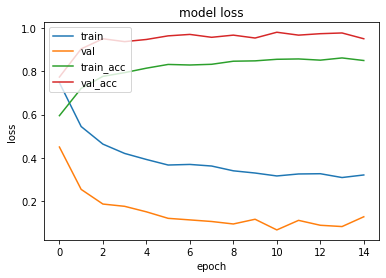

In [16]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val','train_acc','val_acc'], loc='upper left')
plt.show()

In [ ]:
model.save("mask_detector.model", save_format="h5")

In [17]:
testbatch = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    directory="D:/arpit/facemask/test",
    target_size=(224,224),
    batch_size=2,
    shuffle=False
)

Found 74 images belonging to 2 classes.


In [13]:
model.evaluate(testbatch,verbose=1,steps=37)

37/37 [==============================] - 2s 44ms/step - loss: 0.0326 - recall: 0.9865 - precision: 0.9865 - binary_accuracy: 0.9865


[0.03257802873849869,
 0.9864864945411682,
 0.9864864945411682,
 0.9864864945411682]

In [28]:
model.save("facemaskdetectorr.model", save_format="h5")

In [26]:

def plot_confusion_matri(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] Confusion matrix, without normalization
[[43  1]
 [ 0 30]]


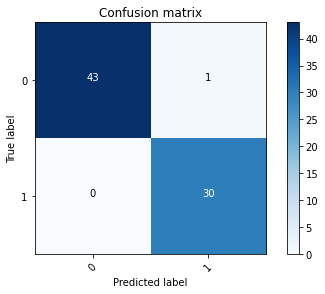

In [27]:
from sklearn.metrics import confusion_matrix
labels= testbatch.classes
testp = model.predict(testbatch,steps=37)
print(testp.argmax(axis=1),end=" ")
cm = confusion_matrix(labels,testp.argmax(axis=1))
cmlabels = ['0','1']
plot_confusion_matri(cm,cmlabels)